# Parabolic SARのデモ

In [1]:
import yfinance as yf
from datetime import datetime, timedelta
from datetime import date
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
import seaborn
import matplotlib.pyplot as plt
import mplfinance.original_flavor as mpf
from collections import deque

In [2]:
ticker = 'USDJPY=X'
end = datetime.today()
start = end - timedelta(days=365)  # 12 months before today
yf.pdr_override()
# yahooサイトからデータをダウンロード
data = pdr.get_data_yahoo(ticker, start, end)

[*********************100%%**********************]  1 of 1 completed


In [3]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-03-01,136.348007,136.462006,135.259995,136.348007,136.348007,0
2023-03-02,136.194000,137.065002,136.087997,136.194000,136.194000,0
2023-03-03,136.705002,136.740005,135.828003,136.705002,136.705002,0
2023-03-06,135.869995,136.179001,135.395004,135.860001,135.860001,0
2023-03-07,135.998993,136.947006,135.580994,135.998993,135.998993,0


In [4]:
class PSAR:

  def __init__(self, init_af=0.02, max_af=0.2, af_step=0.02):
    self.max_af = max_af
    self.init_af = init_af
    self.af = init_af
    self.af_step = af_step
    self.extreme_point = None
    self.high_price_trend = []
    self.low_price_trend = []
    self.high_price_window = deque(maxlen=2)
    self.low_price_window = deque(maxlen=2)

    # Lists to track results
    self.psar_list = []
    self.af_list = []
    self.ep_list = []
    self.high_list = []
    self.low_list = []
    self.trend_list = []
    self._num_days = 0

  def calcPSAR(self, high, low):
    if self._num_days >= 3:
      psar = self._calcPSAR()
    else:
      psar = self._initPSARVals(high, low)

    psar = self._updateCurrentVals(psar, high, low)
    self._num_days += 1

    return psar

  def _initPSARVals(self, high, low):
    if len(self.low_price_window) <= 1:
      self.trend = None
      self.extreme_point = high
      return None

    if self.high_price_window[0] < self.high_price_window[1]:
      self.trend = 1
      psar = min(self.low_price_window)
      self.extreme_point = max(self.high_price_window)
    else: 
      self.trend = 0
      psar = max(self.high_price_window)
      self.extreme_point = min(self.low_price_window)

    return psar

  def _calcPSAR(self):
    prev_psar = self.psar_list[-1]
    if self.trend == 1: # Up
      psar = prev_psar + self.af * (self.extreme_point - prev_psar)
      psar = min(psar, min(self.low_price_window))
    else:
      psar = prev_psar - self.af * (prev_psar - self.extreme_point)
      psar = max(psar, max(self.high_price_window))

    return psar

  def _updateCurrentVals(self, psar, high, low):
    if self.trend == 1:
      self.high_price_trend.append(high)
    elif self.trend == 0:
      self.low_price_trend.append(low)

    psar = self._trendReversal(psar, high, low)

    self.psar_list.append(psar)
    self.af_list.append(self.af)
    self.ep_list.append(self.extreme_point)
    self.high_list.append(high)
    self.low_list.append(low)
    self.high_price_window.append(high)
    self.low_price_window.append(low)
    self.trend_list.append(self.trend)

    return psar

  def _trendReversal(self, psar, high, low):
    # Checks for reversals
    reversal = False
    if self.trend == 1 and psar > low:
      self.trend = 0
      psar = max(self.high_price_trend)
      self.extreme_point = low
      reversal = True
    elif self.trend == 0 and psar < high:
      self.trend = 1
      psar = min(self.low_price_trend)
      self.extreme_point = high
      reversal = True

    if reversal:
      self.af = self.init_af
      self.high_price_trend.clear()
      self.low_price_trend.clear()
    else:
        if high > self.extreme_point and self.trend == 1:
          self.af = min(self.af + self.af_step, self.max_af)
          self.extreme_point = high
        elif low < self.extreme_point and self.trend == 0:
          self.af = min(self.af + self.af_step, self.max_af)
          self.extreme_point = low

    return psar

In [5]:
# パラボリックSARの計算
indic = PSAR()
data['PSAR'] = data.apply(
    lambda x: indic.calcPSAR(x['High'], x['Low']), axis=1)
# Add supporting data
data['EP'] = indic.ep_list
data['Trend'] = indic.trend_list
data['AF'] = indic.af_list

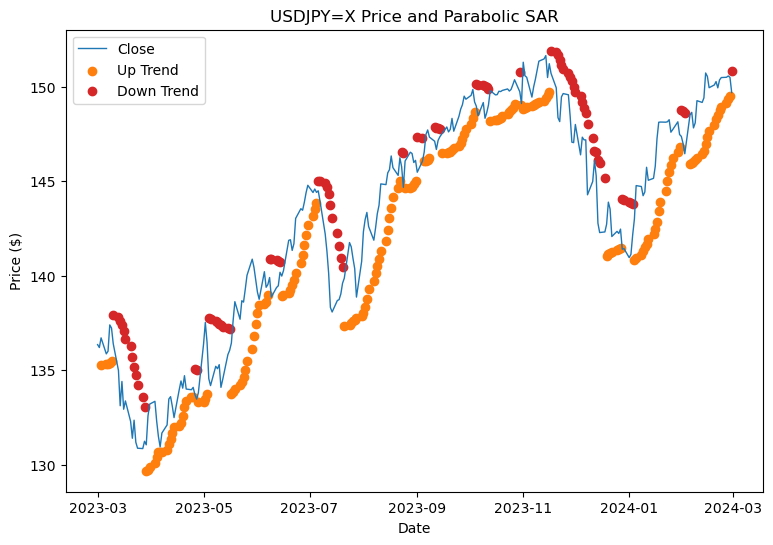

In [6]:
# パラボリックSARの描画
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
psar_bull = data.loc[data['Trend']==1]['PSAR']
psar_bear = data.loc[data['Trend']==0]['PSAR']
plt.figure(figsize=(9, 6))
plt.plot(data['Close'], label='Close', linewidth=1)
plt.scatter(psar_bull.index, psar_bull, color=colors[1], label='Up Trend')
plt.scatter(psar_bear.index, psar_bear, color=colors[3], label='Down Trend')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title(f'{ticker} Price and Parabolic SAR')
plt.legend()
plt.show()

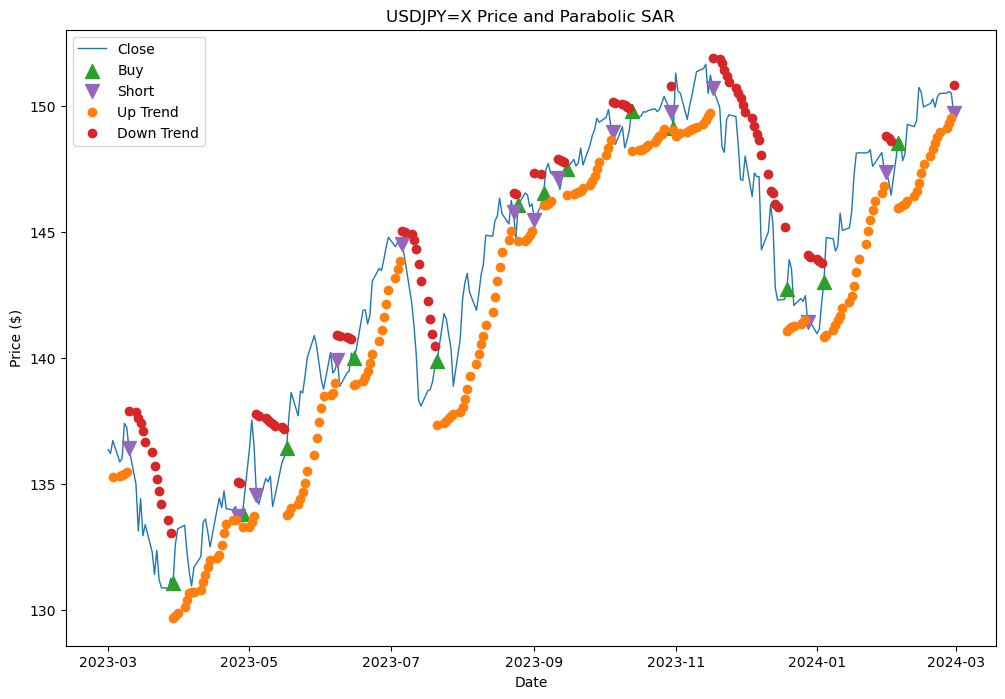

In [7]:
buy_sigs = data.loc[data['Trend'].diff()==1]['Close']
short_sigs = data.loc[data['Trend'].diff()==-1]['Close']

plt.figure(figsize=(12, 8))
plt.plot(data['Close'], label='Close', linewidth=1, zorder=0)
plt.scatter(buy_sigs.index, buy_sigs, color=colors[2], 
            label='Buy', marker='^', s=100)
plt.scatter(short_sigs.index, short_sigs, color=colors[4], 
            label='Short', marker='v', s=100)
plt.scatter(psar_bull.index, psar_bull, color=colors[1], label='Up Trend')
plt.scatter(psar_bear.index, psar_bear, color=colors[3], label='Down Trend')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title(f'{ticker} Price and Parabolic SAR')
plt.legend()
plt.show()